### plotting ROIs

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from nilearn.plotting import plot_stat_map, plot_roi
from nilearn.glm import threshold_stats_img
from nilearn.reporting import get_clusters_table
from nilearn.image import get_data, load_img, new_img_like, index_img
from nilearn.input_data import NiftiLabelsMasker

In [149]:
mask_img = 'rois/Left_Accumbens.nii'

In [150]:
func_file = '../../../TSL_output/smooth_nomask/preproc/sub-06/sub-06_task-tsl_run-1_fwhm-8_bold.nii'

In [151]:
masker = NiftiLabelsMasker(mask_img, resampling_target='data',
                           standardize=True, detrend=True)
#                            standardize=False, detrend=False)   
masker.fit()

NiftiLabelsMasker(detrend=True, labels_img='rois/Left_Accumbens.nii',
                  standardize=True)

In [152]:
mask_data = masker.transform(func_file)

In [153]:
mask_data.shape

(242, 1)

In [134]:
df = pd.read_csv('../model_gen/local_output_mean/fmri_io_jump_freq.csv')

In [109]:
def resample_pmod(df, sj, sess):
    dft = df[(df['subject']==sj) & (df['session']==sess)].copy()
    dft['datetime'] = pd.to_datetime(dft['runtime'], unit='s')
    ds = pd.Series(dft['pmod_mean'].values, index=dft['datetime'])
    pmod_pl = ds.resample('2s').mean().fillna(method='ffill')
    pmod_pl = (pmod_pl - pmod_pl.mean())/pmod_pl.std()
    return pmod_pl

In [141]:
masker = NiftiLabelsMasker(mask_img, resampling_target='data',
                           standardize=True, detrend=True)
#                            standardize=False, detrend=False)   
masker.fit()

NiftiLabelsMasker(detrend=True, labels_img='rois/Left_Accumbens.nii',
                  standardize=True)

In [136]:
func_dir = '../../../TSL_output/smooth_nomask/preproc/'
allsj_ls = []
for sj in os.listdir(func_dir):
    sj_dir = os.path.join(func_dir, sj)
    sj_ls = []
    for f in sorted(os.listdir(sj_dir)):
        # read pmod
        sj_num = int(f.split('_')[0].split('-')[1])
        run_num = int(f.split('_')[2].split('-')[1])
        df_pmod = resample_pmod(df, sj_num, run_num)        
        
        # read roi
        func_file = os.path.join(sj_dir, f)
#         print(func_file)
        mask_data = masker.transform(func_file)
        mask_mean = np.mean(mask_data, 1)
        
        # make df
        df_len = min([len(mask_mean), len(df_pmod)])
        df_tmp = pd.DataFrame({'roi_mean': mask_mean[:df_len], 'pmod_mean': df_pmod[:df_len]})
        sj_ls.append(df_tmp)
    df_sj = pd.concat(sj_ls)
    allsj_ls.append(df_sj)

In [137]:
len(allsj_ls)

35

In [138]:
for s in allsj_ls:
    dff = s
    print(pearsonr(dff['roi_mean'], dff['pmod_mean']))

(0.0145166232435478, 0.653951501648014)
(0.0020951997386809665, 0.9422246898387779)
(-0.033923055734725656, 0.24207281869642935)
(0.007565228627605817, 0.7939836582771683)
(0.0038226566205239957, 0.8948914447655215)
(0.006929810700778079, 0.8107118402711774)
(-0.04228509354281102, 0.1443885319038662)
(0.036456722131194816, 0.20808967822413196)
(-0.02925449447747133, 0.3106621837957397)
(-0.025746264328957165, 0.37468057770151186)
(0.018197906678751142, 0.5283167884197465)
(-0.0075947871298107, 0.8141036690283261)
(-0.024066737435778973, 0.40526662294562465)
(-0.011507830771953389, 0.7220411009892779)
(-0.03204492244427291, 0.26794543731920667)
(-0.05452423722988683, 0.058681106089980686)
(0.04324461820918166, 0.17996534462774696)
(0.023184676204005588, 0.42445412598925697)
(-0.08514061049344979, 0.0032374828194066296)
(-0.008366760682749814, 0.7727268992690711)
(-0.009257873558844247, 0.7487856511192573)
(-0.007556286869151508, 0.7934635100082371)
(0.011530025887394284, 0.6909939296318

In [7]:
mask_ls[0].shape

(242,)

In [110]:
ds = resample_pmod(df, 36, 1)

In [77]:
pmod_pl = ds.resample('2s').mean().fillna(method='ffill')
pmod_pl = (pmod_pl - pmod_pl.mean())/pmod_pl.std()

In [78]:
pmod_pl

datetime
1970-01-01 00:00:00   -0.482865
1970-01-01 00:00:02   -0.831897
1970-01-01 00:00:04    1.196283
1970-01-01 00:00:06   -0.368067
1970-01-01 00:00:08   -0.840930
                         ...   
1970-01-01 00:07:44    2.181365
1970-01-01 00:07:46    2.372347
1970-01-01 00:07:48    0.162440
1970-01-01 00:07:50    1.510490
1970-01-01 00:07:52   -0.251141
Freq: 2S, Length: 237, dtype: float64

In [79]:
from scipy.stats import pearsonr

In [80]:
pearsonr(mask_ls[0][:len(pmod_pl)], pmod_pl)

(0.08312389886724489, 0.20226739534711055)

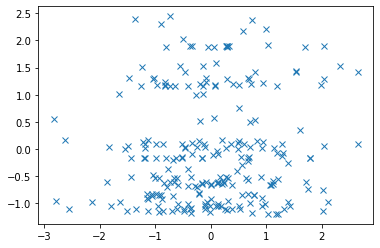

In [81]:
plt.plot(mask_ls[0][:len(pmod_pl)], pmod_pl, 'x')

#### making rois

In [7]:
from nilearn import datasets
# dataset = datasets.fetch_atlas_harvard_oxford('sub-maxprob-thr25-1mm')
dataset = datasets.fetch_atlas_harvard_oxford('cort-maxprob-thr25-2mm')
# dataset = datasets.fetch_atlas_aal('SPM12')
atlas_filename = dataset.maps
labels = dataset.labels

In [8]:
labels

['Background',
 'Frontal Pole',
 'Insular Cortex',
 'Superior Frontal Gyrus',
 'Middle Frontal Gyrus',
 'Inferior Frontal Gyrus, pars triangularis',
 'Inferior Frontal Gyrus, pars opercularis',
 'Precentral Gyrus',
 'Temporal Pole',
 'Superior Temporal Gyrus, anterior division',
 'Superior Temporal Gyrus, posterior division',
 'Middle Temporal Gyrus, anterior division',
 'Middle Temporal Gyrus, posterior division',
 'Middle Temporal Gyrus, temporooccipital part',
 'Inferior Temporal Gyrus, anterior division',
 'Inferior Temporal Gyrus, posterior division',
 'Inferior Temporal Gyrus, temporooccipital part',
 'Postcentral Gyrus',
 'Superior Parietal Lobule',
 'Supramarginal Gyrus, anterior division',
 'Supramarginal Gyrus, posterior division',
 'Angular Gyrus',
 'Lateral Occipital Cortex, superior division',
 'Lateral Occipital Cortex, inferior division',
 'Intracalcarine Cortex',
 'Frontal Medial Cortex',
 'Juxtapositional Lobule Cortex (formerly Supplementary Motor Cortex)',
 'Subcallo

In [9]:
from nilearn.regions import connected_label_regions
region_labels = connected_label_regions(atlas_filename)

In [10]:
region_labels_data = get_data(atlas_filename)

In [11]:
# lb_ls = ['Left Putamen','Left Accumbens','Left Caudate','Right Caudate',
#  'Right Putamen','Right Accumbens']
lb_ls = ['Insular Cortex', 'Postcentral Gyrus', 'Cingulate Gyrus, anterior division']

In [12]:
c = []
for i, x in enumerate(labels):
    for lb in lb_ls:
        if lb==x:
            c.append(i)

In [13]:
c

[2, 17, 29]

In [14]:
# split and save individual rois
for idx in c:
    d = (region_labels_data==idx).astype(int)
    d_img = new_img_like(atlas_filename, d)
#     plot_roi(d_img)
    d_img.to_filename('./rois/'+labels[idx].replace(' ', '_')+'.nii')

#### check extracted ROI ts 

In [3]:
import scipy

def plot_bins(df,sj_idx=None,cut_num=10,model=None):
    """bin average then correlate"""
    fig, ax = plt.subplots(figsize=(4,4))
    all_sj = np.unique(df['subject'])
    if sj_idx is not None:
        sj_ls = all_sj[sj_idx]
    else:
        sj_ls = all_sj
    n_sj = len(sj_ls)
    r_sj = np.empty((n_sj,))
    model_sj = np.empty((n_sj, cut_num))
    rate_sj = np.empty((n_sj, cut_num))
#     for idx, sj in enumerate(np.unique(df['subject'])):
    for idx, sj in enumerate(sj_ls):
        df_sj = df[df['subject']==sj]
        df_tmp = df_sj.dropna(subset=['pmod_mean'])
        model_rank = df_tmp['pmod_mean'].rank(method='max')
        model_cut = df_tmp.groupby(pd.qcut(model_rank, cut_num))['pmod_mean'].mean().values
        rate_cut = df_tmp.groupby(pd.qcut(model_rank, cut_num))['roi_mean'].mean().values
#         print(rate_cut)
        nas = np.logical_and(np.isnan(model_cut), np.isnan(rate_cut)) # get rid of nans
        # demean
#         mc_dm = demean(model_cut[~nas])
#         rc_dm = demean(rate_cut[~nas])
#         pr, pv = scipy.stats.pearsonr(mc_dm, rc_dm)
#         sns.regplot(x=mc_dm, y=rc_dm)
        # no demean
        pr, pv = scipy.stats.pearsonr(model_cut[~nas], rate_cut[~nas])
#         print(f'subject %d, pearsonr %.3f, pval %.3f' %(sj, pr, pv))
        if pr > 0:
            color = '#0277BD'
        else:
            color = '#B71C1C'
        sns.regplot(x=model_cut[~nas], y=rate_cut[~nas], color=color, ax=ax, ci=None,
                    scatter_kws={'alpha':0.3}, line_kws={'linewidth':1})      
        
        r_sj[idx] = pr
        model_sj[idx,:] = model_cut
        rate_sj[idx,:] = rate_cut


#     ax.set_aspect('equal')#, adjustable='box')
#     plt.plot([0,1],[0,1], 'k-')
#     plt.xlim(.3,.7)
#     plt.ylim(0,1)
    # plt.xlim(0.,1)
    # plt.ylim(0.,1)
    plt.xlabel('model probability p(L)')
    plt.ylabel('ROI activations')
    t0, p0 = scipy.stats.ttest_rel(r_sj,np.zeros((n_sj,)))
    print(np.mean(r_sj), t0, p0)
#     plt.title(f'Pearson r={np.mean(r_sj):.3f} (t({len(r_sj)})={t0:.3f}, p={p0:.3e})')
    plt.title(f'mean r={np.mean(r_sj):.3f}***')
    if model is not None:
        fig_name = f'bins_{model:s}.pdf'
        fig_path = os.path.join('figs',fig_name)
        plt.savefig(fig_path, bbox_inches='tight')

def demean(df):
    """demean"""
    df_dm = (df-np.mean(df))/np.std(df)
    return df_dm

0.2 1.1902380714238083 0.24219738438875124


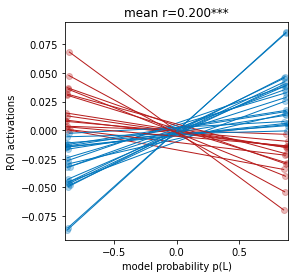

In [4]:
df = pd.read_csv('./output/Left_Putamen.csv')
plot_bins(df, sj_idx=None, model=None, cut_num=2)
# plt.savefig('./figs/bins_fmri_io_jump_freq_all.png', bbox_inches='tight')

-0.14285714285714285 -0.841625411530173 0.4058785652294502


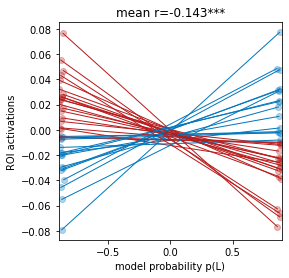

In [5]:
df = pd.read_csv('./output/Left_Accumbens.csv')
plot_bins(df, sj_idx=None, model=None, cut_num=2)
# plt.savefig('./figs/bins_fmri_io_jump_freq_all.png', bbox_inches='tight')

-0.02857142857142857 -0.16666666666666666 0.8686195887239642


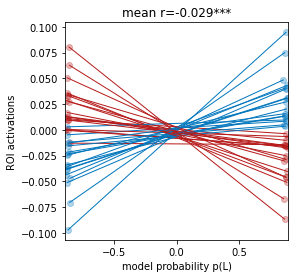

In [7]:
df = pd.read_csv('./output/Left_Caudate.csv')
plot_bins(df, sj_idx=None, model=None, cut_num=2)
# plt.savefig('./figs/bins_fmri_io_jump_freq_all.png', bbox_inches='tight')

-0.2 -1.1902380714238083 0.24219738438875124


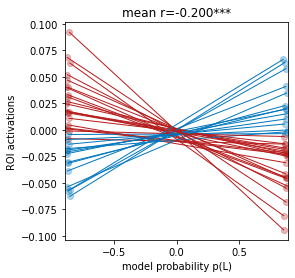

In [10]:
df = pd.read_csv('./output/Right_Accumbens.csv')
plot_bins(df, sj_idx=None, model=None, cut_num=2)
# plt.savefig('./figs/bins_fmri_io_jump_freq_all.png', bbox_inches='tight')

0.08571428571428572 0.501642040544954 0.6191523108231272


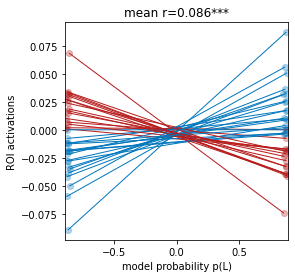

In [11]:
df = pd.read_csv('./output/Right_Caudate.csv')
plot_bins(df, sj_idx=None, model=None, cut_num=2)
# plt.savefig('./figs/bins_fmri_io_jump_freq_all.png', bbox_inches='tight')

In [ ]:
df = pd.read_csv('./output/Right_Putamen.csv')
plot_bins(df, sj_idx=None, model=None, cut_num=10)
# plt.savefig('./figs/bins_fmri_io_jump_freq_all.png', bbox_inches='tight')

-0.08571428571428572 -0.501642040544954 0.6191523108231272


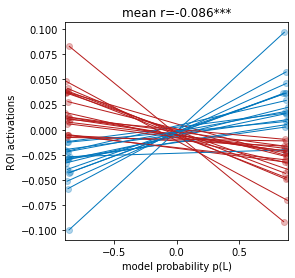

In [13]:
df = pd.read_csv('./output/Cingulate_Gyrus,_anterior_division.csv')
plot_bins(df, sj_idx=None, model=None, cut_num=2)
# plt.savefig('./figs/bins_fmri_io_jump_freq_all.png', bbox_inches='tight')

-0.37142857142857144 -2.332656828337139 0.025721627388830017


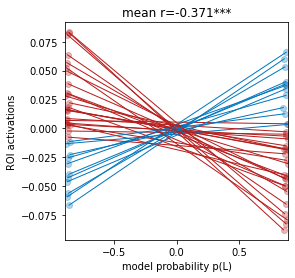

In [14]:
df = pd.read_csv('./output/Insular_Cortex.csv')
plot_bins(df, sj_idx=None, model=None, cut_num=2)
# plt.savefig('./figs/bins_fmri_io_jump_freq_all.png', bbox_inches='tight')

In [14]:
# load data and get display threshold
img = '../../../TSL_output/2ndLevel_io_jf_prob_mean_FDR0001/2ndLevel/con_0002/spmT_0001_thr.nii'
clean_map, threshold = threshold_stats_img(
    img, alpha=.001, height_control='fpr', cluster_threshold=10)

In [17]:
# get peak coordinates for plotting
table = get_clusters_table(clean_map, stat_threshold=threshold,
                           cluster_threshold=10)
# print(table)
table[['X','Y','Z']] = table[['X','Y','Z']].astype(int)
table[['Peak Stat']] = table[['Peak Stat']].round(3)
peaks = table[table['Cluster Size (mm3)'].astype(str).apply(lambda x: len(x))>0]

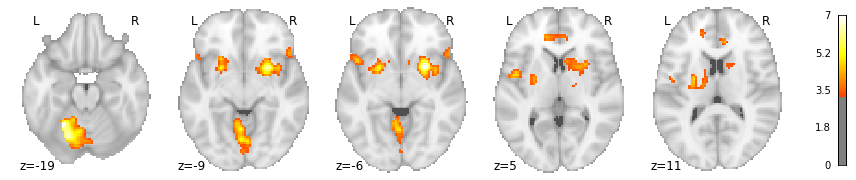

In [19]:
# plot cluster peaks
peak_z = np.unique(peaks['Z'])
g = plot_stat_map(clean_map, threshold=threshold, vmax=7,
              display_mode='z', cut_coords=(peak_z)) 

In [29]:
load_img(img)

In [47]:
# building masks from clusters 
img_data = get_data(img)#.astype(bool)
thresholded_img = new_img_like(img, img_data>3.3)

In [61]:
all_cluster_mask = get_data(load_img(thresholded_img)).astype(np.int)

In [62]:
sum(sum(sum(all_cluster_mask==1)))

1558

In [65]:
mask_img = new_img_like(img, all_cluster_mask)

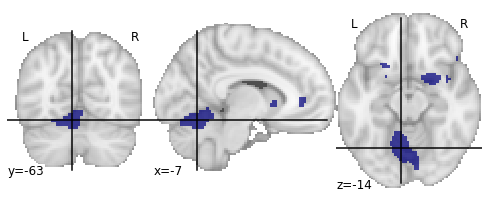

In [67]:
plot_roi(mask_img)

In [68]:
from scipy import ndimage

In [69]:
dil_all_cluster_mask = ndimage.binary_dilation(all_cluster_mask)

In [70]:
dil_all_cluster_mask_img = new_img_like(img, dil_all_cluster_mask.astype(np.int))

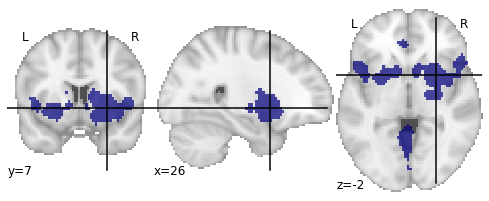

In [71]:
plot_roi(dil_all_cluster_mask_img)

In [193]:
labels, n_labels = ndimage.label(dil_all_cluster_mask)
# labels, n_labels = ndimage.label(all_cluster_mask)

In [195]:
labels.shape

(81, 96, 63)

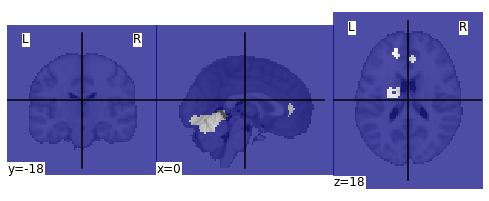

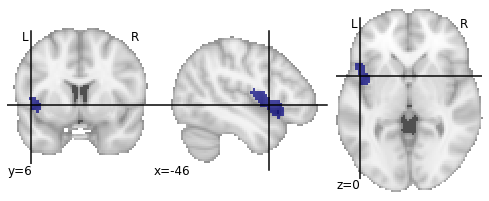

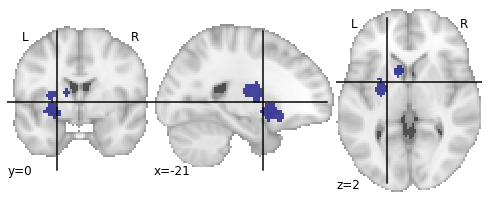

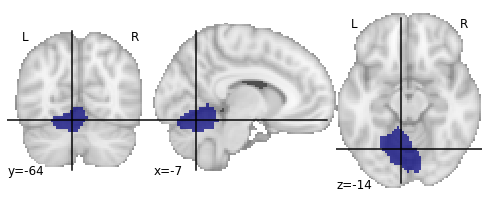

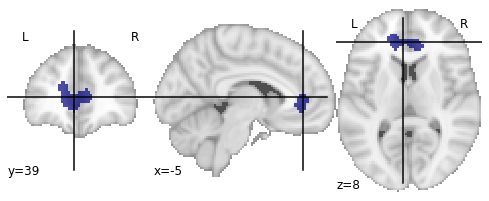

In [91]:
for n in range(n_labels):
    d = (labels==n).astype(int)
    d_img = new_img_like(img, d)
    plot_roi(d_img)

In [122]:
from nilearn import datasets
dataset = datasets.fetch_atlas_harvard_oxford('sub-maxprob-thr25-1mm')
# dataset = datasets.fetch_atlas_harvard_oxford('sub-prob-2mm')
atlas_filename = dataset.maps
labels = dataset.labels

In [130]:
from nilearn.regions import connected_label_regions
region_labels = connected_label_regions(atlas_filename)

In [147]:
region_labels_data = get_data(atlas_filename)

In [139]:
lb_ls = ['Left Putamen','Left Accumbens','Left Caudate','Right Caudate',
 'Right Putamen','Right Accumbens']

In [143]:
c = []
for i, x in enumerate(labels):
    for lb in lb_ls:
        if lb==x:
            c.append(i)

In [144]:
c

[5, 6, 11, 16, 17, 21]

In [158]:
# split and save individual rois
for idx in c:
    d = (region_labels_data==idx).astype(int)
    d_img = new_img_like(atlas_filename, d)
#     plot_roi(d_img)
    d_img.to_filename('./rois/'+labels[idx].replace(' ', '_')+'.nii')

In [155]:
# # check
# for f in os.listdir('./rois'):
#     plot_roi('./rois/' + f)

In [159]:
# extract ts
func_file = '../../../TSL_output/1stLevel_io_jf_prob_mean/1stLevel/sub-06/con_0002.nii'

In [160]:
mask_img = './rois/Left_Accumbens.nii'

In [208]:
from nilearn.image import resample_to_img
stat_img = mask_img
template = func_file
resampled_stat_img = resample_to_img(stat_img, template)
resampled_mask_data = get_data(resampled_stat_img).astype(np.int)
resampled_mask_img = new_img_like(template, resampled_mask_data)

/home/fs0/syzhang/.local/lib/python3.8/site-packages/nilearn/image/resampling.py:512: UserWarning: Casting data from int64 to float64
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))


In [211]:
load_img(func_file).shape

(81, 96, 63)

In [209]:
resampled_mask_img.shape

(81, 96, 63)

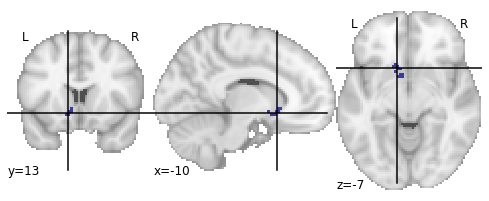

In [172]:
plot_roi(resampled_mask_img)

In [239]:
from nilearn.masking import apply_mask
func_file = '../../../TSL_output/smooth_nomask/preproc/sub-06/sub-06_task-tsl_run-1_fwhm-8_bold.nii'
masked_data = apply_mask(func_file, resampled_mask_img)

In [240]:
masked_data.shape

(242, 26)

In [241]:
import matplotlib.pyplot as plt

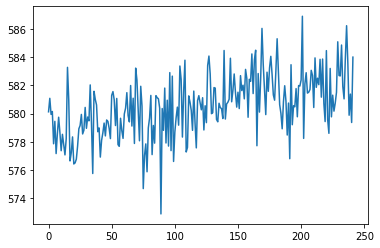

In [242]:
plt.plot(np.mean(masked_data,1))

In [243]:
from nilearn.input_data import NiftiLabelsMasker

In [249]:
masker = NiftiLabelsMasker(mask_img, resampling_target='data',
                           standardize=True, detrend=True)

In [250]:
masker.fit()

NiftiLabelsMasker(detrend=True, labels_img='./rois/Left_Accumbens.nii',
                  standardize=True)

In [251]:
mask_data = masker.transform(func_file)

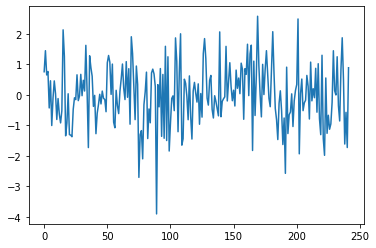

In [252]:
plt.plot(np.mean(mask_data,1))